<a href="https://colab.research.google.com/github/xxxcrttt/SPS/blob/main/sps_lecture2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install ipympl

     |████████████████████████████████| 507 kB 5.0 MB/s 


In [ ]:
import numpy as np
import torch as t
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import FloatSlider, IntSlider, interact, interact_manual
%matplotlib widget

# Lecture 2: 
## Overfitting, regularization and cross-validation 

### Varierties of overfitting -- 过拟合问题

#### Too little data -- 数据过少



interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

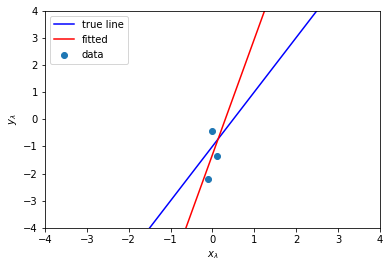

In [ ]:
def bias(X):
  return t.cat([X, t.ones(X.shape[0], 1)], 1)

def fit_wh(X, Y):
  return t.inverse(X.T @ X) @ X.T @ Y 

def plot():
  N     = 3
  D     = 1 
  sigma = 0.5
  X     = t.tensor([[-0.1], [0], [0.1]])
  Xe    = bias(X)
  Wtrue = t.tensor([[2.], [-1]])
  Y     = Xe @ Wtrue + sigma*t.randn(N, 1)
  Wh    = fit_wh(Xe, Y)

  fig, ax = plt.subplots()
  ax.set_xlabel("$x_\lambda$")
  ax.set_ylabel("$y_\lambda$")
  ax.set_xlim(-4, 4)
  ax.set_ylim(-4, 4)
  ax.scatter(X, Y, label="data");

  xs = t.linspace(-4, 4, 100)[:, None]
  ax.plot(xs, bias(xs)@Wtrue, 'b', label="true line")
  ax.plot(xs, bias(xs)@Wh, 'r', label="fitted")
  ax.legend()

interact_manual(plot);

#### Too little data in some directions

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

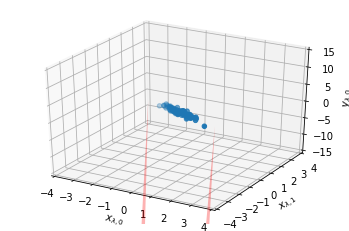

In [ ]:
def plot():
    N     = 100   # number of datapoints
    D     = 2   # dimension of datapoints
    sigma = 0.5 # output noise
    rand = t.randn(N, 1)
    X     = t.cat([rand, -rand], 1) + 1E-3*t.randn(N, 2)
    Wtrue = t.tensor([[1.], [-1.]])
    Y     = X @ Wtrue + sigma*t.randn(N, 1)
    Wh    = fit_wh(X, Y)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("$x_{\lambda, 0}$")
    ax.set_ylabel("$x_{\lambda, 1}$")
    ax.set_zlabel("$y_{\lambda, 0}$")
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_zlim(-15, 15)
    ax.scatter(X[:, 0], X[:, 1], Y[:, 0])

    Xp = t.tensor([
        [-4., -4.],
        [-4.,  4.],
        [ 4., -4.],
        [ 4.,  4.]
    ])

    ax.plot_trisurf(
        np.array(Xp[:, 0]), 
        np.array(Xp[:, 1]), 
        np.array((Xp @ Wh)[:, 0]), 
        color='r', 
        alpha=0.3
    )
    
interact_manual(plot);

#### The function class is too complex

consider **Chebyshev polynomials**, they are defined on $-1 \leq x \leq 1$ and range from $-1 \leq y \leq 1$.

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

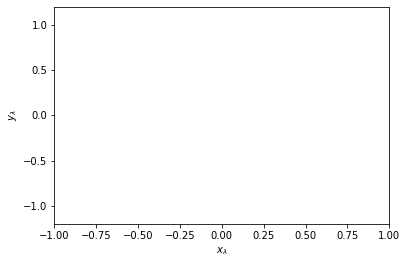

In [ ]:
def cheb(xs, c):
    # c is int
    coefs = c*[0] + [1]
    return np.polynomial.chebyshev.chebval(xs, coefs)

xs = np.linspace(-1, 1, 100)

fig, ax = plt.subplots()
ax.set_xlabel("$x_\lambda$")
ax.set_ylabel("$y_\lambda$")
ax.set_xlim(-1, 1)
ax.set_ylim(-1.2, 1.2)

i = 0
def add_line():
    global i
    ax.plot(xs, cheb(xs, i))
    i += 1
interact_manual(add_line);

interactive(children=(IntSlider(value=1, description='order', max=10, min=1), Button(description='Run Interact…

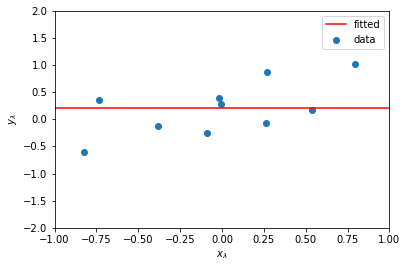

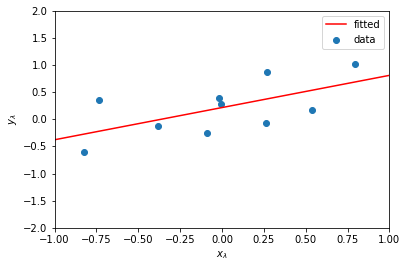

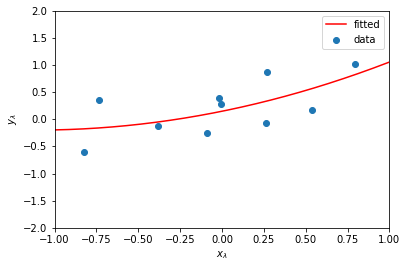

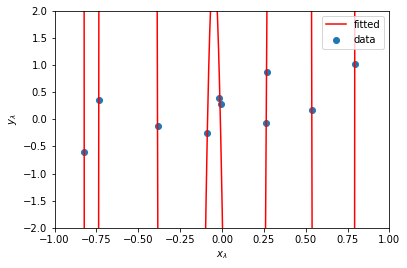

In [ ]:
def chebX(X, order):
    assert (-1 <= X).all() and (X <= 1).all()
    
    xs = []
    for c in range(order):
        xs.append(cheb(X, c))
    return t.cat(xs, 1)
   
N     = 10  # number of datapoints
D     = 1   # dimension of datapoints
sigma = 0.5 # output noise
t.manual_seed(0)
rand  = t.rand(N, 1)
X     = 2*rand - 1
Wtrue = t.tensor([[0.2], [0.5]])
Y     = chebX(X, 2) @ Wtrue + sigma*t.randn(N, 1)


def plot(order):
    Xe    = chebX(X, order)
    Wh    = fit_wh(Xe, Y)
    print(f"Wtrue = {Wtrue.T}")
    print(f"Wh = {Wh.T}")
    
    fig, ax = plt.subplots()
    ax.set_xlabel("$x_\lambda$")
    ax.set_ylabel("$y_\lambda$")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-2, 2)
    ax.scatter(X, Y, label="data");

    xs = t.linspace(-1, 1, 1000)[:, None]
    ax.plot(xs, chebX(xs, order)@Wh, 'r', label="fitted")
    ax.legend()
    
interact_manual(plot, order=IntSlider(min=1, max=10));

### Cross-Validation 交叉验证

We split the data into **training** and **validation** sets. 

We train the model on the training set, then look at the residuals/errors on the validation set. And choose the model with the smallest cross-validation error.

interactive(children=(IntSlider(value=1, description='order', max=10, min=1), Button(description='Run Interact…

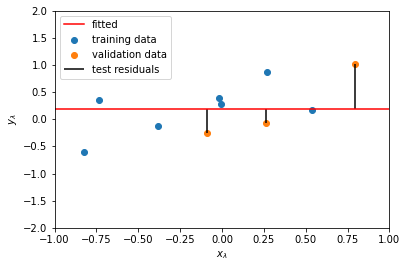

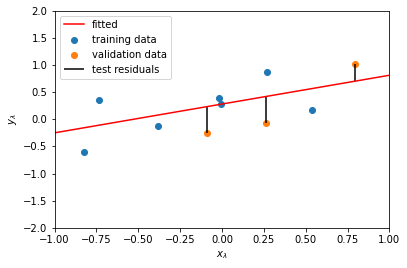

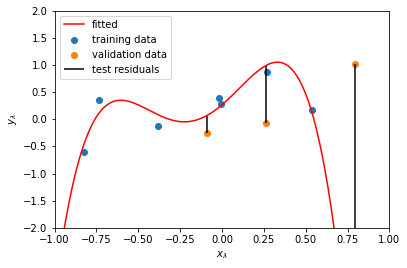

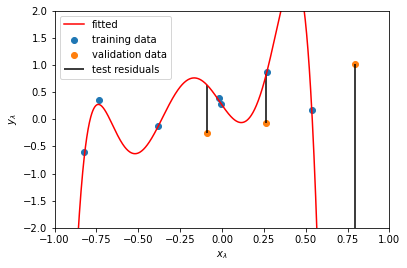

In [ ]:
X_train = X[:7]
X_test  = X[7:]

Y_train = Y[:7]
Y_test  = Y[7:]

def plot(order):
  Wh = fit_wh(chebX(X_train, order),Y_train)

  Yh_test = chebX(X_test, order) @ Wh
  cross_validation_error = ((Y_test - Yh_test)**2).mean() # mean square error
  print(f"cross_validation_error:{cross_validation_error}")

  fig, ax = plt.subplots()
  ax.set_xlabel("$x_\lambda$")
  ax.set_ylabel("$y_\lambda$")
  ax.set_xlim(-1, 1)
  ax.set_ylim(-2, 2)
  ax.scatter(X_train, Y_train, label="training data");
  ax.scatter(X_test, Y_test, label="validation data");
  ax.vlines(X_test, Y_test, Yh_test, label="test residuals")
    

  xs = t.linspace(-1, 1, 1000)[:, None]
  ax.plot(xs, chebX(xs, order)@Wh, 'r', label="fitted")
  ax.legend()
    
interact_manual(plot, order=IntSlider(min=1, max=10));


#### K-fold cross-validation K折交叉验证

Split the data up into train/validation sets in multiple different ways. 

### Regularisation 正则化
-- have lots of noise, and can't control by just using a simple linear model.

**penalise the weights** -- using the diagonal matrix $Λ$.

\begin{align}
  L(w) &= log P(y| X, w) - \tfrac{1}{2} w^T \Lambda w
\end{align}

\begin{align}
  ŵ &= ((X^T X)^{-1} + \sigma^2 Λ)^{-1} X y
\end{align}


regularisation explicity penalises large weights, and gives more sensible solutions.

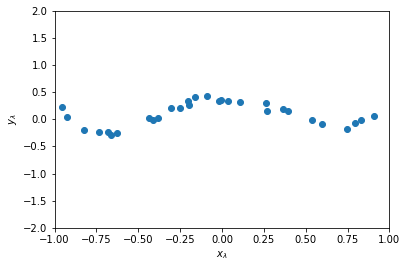

In [ ]:
N     = 30  # number of datapoints
D     = 1   # dimension of datapoints
sigma = 0.2 # output noise
t.manual_seed(0)
rand  = t.rand(N, 1)
X     = 2*rand - 1
Wtrue = t.tensor([[0.], [0.], [0.], [0.], [0.3]])
Y     = chebX(X, 5) @ Wtrue + sigma*t.rand(N, 1)

fig, ax = plt.subplots()
ax.set_xlabel("$x_\lambda$")
ax.set_ylabel("$y_\lambda$")
ax.set_xlim(-1, 1)
ax.set_ylim(-2, 2)

ax.scatter(X, Y);

interactive(children=(IntSlider(value=1, description='order', max=12, min=1), FloatSlider(value=0.0, descripti…

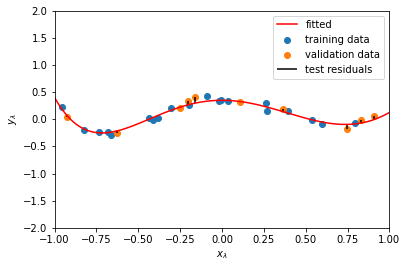

In [ ]:
X_train = X[:20]
X_test  = X[20:]

Y_train = Y[:20]
Y_test  = Y[20:]

def fit_reg_wh(X, Y, reg):
  # reg = sigma**2 * lambda
  return t.inverse(X.T @ X + reg*t.eye(X.shape[1])) @ X.T @ Y

def plot(order, reg):
  Wh    = fit_reg_wh(chebX(X_train, order), Y_train, reg)

  Yh_test = chebX(X_test, order) @ Wh
  cross_validation_error = ((Y_test - Yh_test)**2).mean()

  print(f"cross validation error: {cross_validation_error}")
  print(f"Wh: {Wh.T}")
    
  fig, ax = plt.subplots()
  ax.set_xlabel("$x_\lambda$")
  ax.set_ylabel("$y_\lambda$")
  ax.set_xlim(-1, 1)
  ax.set_ylim(-2, 2)
  ax.scatter(X_train, Y_train, label="training data");
  ax.scatter(X_test, Y_test, label="validation data");
  ax.vlines(X_test, Y_test, Yh_test, label="test residuals")
    

  xs = t.linspace(-1, 1, 1000)[:, None]
  ax.plot(xs, chebX(xs, order)@Wh, 'r', label="fitted")
  ax.legend()
    
interact_manual(plot, order=IntSlider(min=1, max=12), reg=FloatSlider(min=0, max=2));

#### Automatic selection of the regulariser using cross-validation 
#### 使用交叉验证自动选择正则化器

-- have to choose a regulariser, dont know the type 

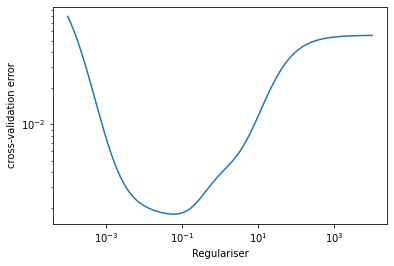

In [ ]:
def cv(order, reg):
  Wh = fit_reg_wh(chebX(X_train, order), Y_train, reg)

  Yh_test = chebX(X_test, order) @ Wh
  return ((Y_test - Yh_test)**2).mean()

log_10_regs = np.linspace(-4, 4, 100)
regs = 10**log_10_regs
cv_errors = np.array([cv(10, reg) for reg in regs])

fig, ax = plt.subplots()
ax.set_xlabel('Regulariser')
ax.set_ylabel('cross-validation error')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(regs, cv_errors);


cross validation error: 0.001789246336556971
Wh: tensor([[ 0.0794, -0.0281, -0.0228, -0.1064,  0.2560, -0.0821, -0.0195, -0.0348,
         -0.0195, -0.0390]])


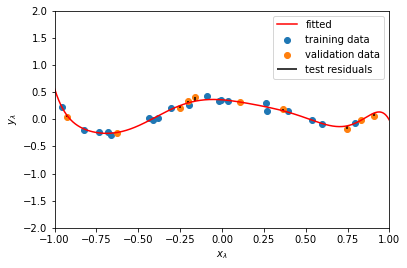

In [ ]:
# select the regulariser with the lowest cross-validation error 
best_reg = regs[np.argmin(cv_errors)]
plot(order=10, reg=best_reg)

#### Limits of cross-validation 
* parameter sweeps can be numerically costly 参数扫描在数值上可能是昂贵的
* splitting the data into validation sets could give less data for training
* scales poorly when you want to cross-validation many different parameters
